In [1]:
from owslib.wmts import WebMapTileService
import json
import requests
import pandas as pd
from geopy.distance import great_circle
import matplotlib.pyplot as plt
import pyproj

In [6]:
wmts = WebMapTileService('https://avoin-karttakuva.maanmittauslaitos.fi/avoin/wmts')
standardized_rendering_pixel_size = 0.00028

The webmap tile service can be used for getting the images and calculating the coordinates of them

In [7]:
print('possible maps:', list(wmts.contents.keys()))
print('possible coordinate system:', list(wmts.tilematrixsets.keys()))


possible maps: ['kiinteistotunnukset', 'selkokartta', 'taustakartta', 'kiinteistojaotus', 'ortokuva', 'maastokartta']
possible coordinate system: ['ETRS-TM35FIN', 'WGS84_Pseudo-Mercator']


In [8]:
# tile = wmts.gettile(layer='ortokuva',tilematrixset='ETRS-TM35FIN',tilematrix='1',row=1,column=1,format="image/jpeg")


In [9]:
content_orto = wmts.contents['ortokuva']
tileset = wmts.tilematrixsets['ETRS-TM35FIN']


The data from the xml that cannot be parsed yet
```xml
<ows:LowerCorner>-548576.000000 6291456.000000</ows:LowerCorner>
<ows:UpperCorner>1548576.000000 8388608.000000</ows:UpperCorner>
```
it is in the following format <lon,lat>
```python
   #ll = LowerCorner
   #ur = UpperCorner
 self.boundingBoxWGS84 = (ll[0], ll[1], ur[0], ur[1])
 ```


In [10]:
tileset.boundingBoxWGS84 = (-548576.000000, 6291456.000000, 1548576.000000, 8388608.000000)


In [11]:
list_of_tilematrixes = list(tileset.tilematrix.keys())
tilematrix = tileset.tilematrix[list_of_tilematrixes[0]]


In [12]:
def convert_fin_to_lat_lon(lat, lon,src='epsg:3067'):
    proj_latlon = pyproj.Proj(init=src) # default: WGS84
    proj_etrs = pyproj.Proj(init='epsg:4326') # ETRS-TM35FIN
    transformed = pyproj.transform(proj_latlon, proj_etrs, lon, lat)
    return transformed


In [13]:
def calculate_distance(lat, lon, lat1, lon1):
    lat_lon = (lat, lon)
    lat_lon1 = (lat1, lon1)
    return great_circle(lat_lon, lat_lon1)


def distance_meter(lat, lon, lat1, lon1):
    return calculate_distance(lat, lon, lat1, lon1).m


def distance_kilometer(lat, lon, lat1, lon1):
    return calculate_distance(lat, lon, lat1, lon1).km


def calculate_distance_finnish(lat, lon, lat1, lon1, distance_type='km'):
    get_ = convert_fin_to_lat_lon(lat, lon)
    get_1 = convert_fin_to_lat_lon(lat1, lon1)
    if distance_type == 'm':
        distance_func = distance_meter
    else:
        distance_func = distance_kilometer
    return distance_func(get_[1], get_[0], get_1[1], get_1[0])


In [14]:
def getWidthHeightCoveredByMatrix(matrix, distance_type=None):
    delta_width = matrix.tilewidth * standardized_rendering_pixel_size * matrix.scaledenominator
    delta_height = matrix.tileheight * standardized_rendering_pixel_size * matrix.scaledenominator
    lon1 = matrix.topleftcorner[0] + delta_width
    lat1 = matrix.topleftcorner[1] - delta_height
    distance = calculate_distance_finnish(lon=matrix.topleftcorner[0],
                                          lat=matrix.topleftcorner[1],
                                          lon1=lon1,
                                          lat1=lat1, distance_type=distance_type)
    return distance


In [41]:
getWidthHeightCoveredByMatrix(tileset.tilematrix[list_of_tilematrixes[5]])

91.1819394726451

In [24]:
def getBoxesByMatrix(matrix):
    delta_width = matrix.tilewidth * standardized_rendering_pixel_size * matrix.scaledenominator
    delta_height = matrix.tileheight * standardized_rendering_pixel_size * matrix.scaledenominator
    boxes_dict = dict()
    for tile_height_pos in range(matrix.matrixheight):
        for tile_width_pos in range(matrix.matrixwidth):
            left_lon = matrix.topleftcorner[0] + (tile_width_pos * delta_width)
            left_lat = matrix.topleftcorner[1] - (tile_height_pos * delta_height)
            right_lon = matrix.topleftcorner[0] + ((tile_width_pos + 1) * delta_width)
            right_lat = matrix.topleftcorner[1] - ((tile_height_pos + 1) * delta_height)
            left = convert_fin_to_lat_lon(lat=left_lat, lon=left_lon)
            right = convert_fin_to_lat_lon(right_lat, right_lon)
            combined = dict(left=left, right=right)
            boxes_dict[tile_height_pos, tile_width_pos] = combined
    return boxes_dict

def get_boxes_by_df(matrix):
    boxes = getBoxesByMatrix(matrix)
    df = pd.DataFrame(boxes).T
    df_ = pd.concat([df['left'].apply(pd.Series),df['right'].apply(pd.Series)], keys=['left','right'], axis=1)
    return df_

In [42]:
df_ = get_boxes_by_df(tileset.tilematrix[list_of_tilematrixes[5]])

In [43]:
def plot_rectangles(df):

    fig,ax = plt.subplots(1,1)
    color_items = ['blue','yellow','red','green']
    count=0
    for x in df.values:
        if count == len(color_items):
            count =0
        rect = plt.Rectangle([x[0],x[1]], x[2]-x[0], x[3]-x[1],color=color_items[count])
        count+=1

    #     print(rect)
        ax.add_patch(rect)
    ax.autoscale_view()
    

In [33]:

df_.shape
#example on how search for certain things in multindexed panda dataframe:
# 1 is N/Latitude 0 is E/Longitude
df_[df_['left'][0]>0]

left                 right           
             0          1          0          1
0 1   8.757447  74.853504  27.000000  70.882750
  2  27.000000  75.582570  41.069799  70.335833
  3  45.242553  74.853504  53.699144  68.792674
1 0   0.300856  68.792674  15.509624  65.748556
  1  12.930201  70.335833  27.000000  66.180524
  2  27.000000  70.882750  38.490376  65.748556
  3  41.069799  70.335833  49.191568  64.507315
2 0   4.808432  64.507315  17.243339  61.123252
  1  15.509624  65.748556  27.000000  61.475423
  2  27.000000  66.180524  36.756661  61.123252
  3  38.490376  65.748556  46.037390  60.100640
3 0   7.962610  60.100640  18.476788  56.474125
  1  17.243339  61.123252  27.000000  56.767054
  2  27.000000  61.475423  35.523212  56.474125
  3  36.756661  61.123252  43.738003  55.617964

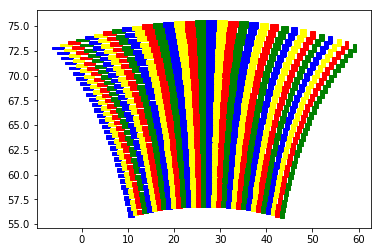

In [45]:
plot_rectangles(df_)

In [99]:
lat=5
lon=73
index_ = df_[(df_['left'][0]<=lat) &(lat<=df_['right'][0]) & (df_['left'][1]>=lon) & (lon>=df_['right'][1])].index
codes = index_.to_list()[-1]

(2, 5)